In [ ]:
# Install necessary libraries
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install tikzplotlib
!pip install grape
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (set

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [1]:
# basics
import numpy as np
import pandas as pd
import tensorflow as tf

# math
from math import ceil
from math import log
from math import log10

# utils
import itertools as it
import time
#from varname import nameof # get the name of a variable
import pickle
from tqdm.auto import tqdm, trange
#from tqdm import tqdm  RuntimeError: CUDA error: device-side assert triggered
import inspect
from grape.datasets.linqs import get_words_data # words information is excluded
import glob


# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import tikzplotlib
#from barplots import barplots
import matplotlib.colors as colors
import seaborn as sns

# torch geometrics

import torch
import torch.optim as optim

from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx, DistMult, RotatE, TransE
from torch_geometric.data import Data

import os.path as osp

# Convolutional GNN

import torch_geometric.transforms as T

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader

from sklearn.metrics import roc_auc_score

2024-10-29 20:10:10.707717: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 20:10:10.755762: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-29 20:10:11.452345: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/khushboo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# Load graph
view=2
view_name='VIEW'+str(view)
results = pd.DataFrame()

# Load graph
view_path='/home/khushboo/VIEW2/VIEW'+str(view)+"/"

nodes_df = pd.read_pickle(view_path+"nodes.pkl")
edges_df = pd.read_pickle(view_path+"edges.pkl")

In [3]:
# TRAIN DATASET

nodes_df.to_csv(view_path+"nodes.csv", header=False, index=False, sep='\t')
edges_df.to_csv(view_path+"edges.csv", header=False, index=False, sep='\t')

In [4]:
nodes_df

,name,type
0,<http://purl.obolibrary.org/obo/SO_0000561>,Sequence
1,<http://purl.obolibrary.org/obo/HP_0033340>,Phenotype
2,<http://purl.obolibrary.org/obo/UBERON_0034713>,Anatomy
3,<http://www.ncbi.nlm.nih.gov/gene/57413>,Gene
4,<https://www.mirbase.org/mature/MIMAT0022474>,miRNA
...,...,...
85294,<http://purl.obolibrary.org/obo/HP_0012854>,Phenotype
85295,<http://purl.obolibrary.org/obo/HP_0031955>,Phenotype
85296,<http://purl.obolibrary.org/obo/HP_0006336>,Phenotype
85297,<http://purl.obolibrary.org/obo/MONDO_0700145>,Disease


In [5]:
edges_df

,subject,predicate,object,type
0,<https://www.mirbase.org/mature/MIMAT0018099>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/85463>,Involved in regulation of
1,<https://www.mirbase.org/mature/MIMAT0004774>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/4856>,Involved in regulation of
2,<https://www.mirbase.org/mature/MIMAT0019073>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/1292>,Involved in regulation of
3,<https://www.mirbase.org/mature/MIMAT0022470>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/9886>,Involved in regulation of
4,<https://www.mirbase.org/mature/MIMAT0004953>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/55806>,Involved in regulation of
...,...,...,...,...
1149167,<http://purl.obolibrary.org/obo/NCIT_C12736>,<http://purl.obolibrary.org/obo/NCIT_R81>,<http://purl.obolibrary.org/obo/NCIT_C12664>,Anatomic_structure_has_location
1149168,<http://purl.obolibrary.org/obo/UBERON_0001875>,<http://purl.obolibrary.org/obo/RO_0002225>,<http://purl.obolibrary.org/obo/UBERON_0001894>,Develops from part of
1149169,<http://purl.obolibrary.org/obo/CL_0000163>,<http://purl.obolibrary.org/obo/RO_0002339>,<http://purl.obolibrary.org/obo/UBERON_0001009>,Has target end location
1149170,<http://purl.obolibrary.org/obo/UBERON_0001131>,<http://purl.obolibrary.org/obo/RO_0002571>,<http://purl.obolibrary.org/obo/UBERON_0010913>,Lumen of


In [6]:
# One-hot encoding of the types
class TypeOneHotEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for type in col.split(self.sep):
                x[i, mapping[type]] = 1
        return x

# Integer encoding for types
class TypeIntegerEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), 1)
        for i, type in enumerate(df.values):
                x[i] = mapping[type]
        return x.to(torch.float)

In [7]:
def load_node_df(df, index_col, encoders=None, **kwargs):

    # Integer encoding for the types
    type_mapping: Dict[str, int] = {}

    df = df.set_index(index_col)
    # Create te mapping for the index
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    # Create the features for the nodes
    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

def load_edge_df(df, src_index_col, src_mapping, dst_index_col, dst_mapping,
                 pred_index_col=None, pred_mapping=None, encoders=None, **kwargs):

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    # Edge Types
    edge_attr = None
    # Edge mapping
    if pred_mapping is not None:
        edge_attrs = torch.zeros(len(df), 1)
        for i, type in enumerate(df[pred_index_col].values):
            edge_attrs[i] = pred_mapping[type]
        edge_attr = edge_attrs.to(torch.int64)
    # No mapping but encoder
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [8]:
# Train

nodes_x, node_mapping = load_node_df(nodes_df, index_col='name',
                                     encoders={'type': TypeIntegerEncoder()}
                                    )

# Edge type mapping (same for train/test)
pred_mapping = {index: i for i, index in enumerate(edges_df.predicate.unique())}

edge_index, edge_type = load_edge_df(
    edges_df,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

In [12]:
data = Data(x=nodes_x, edge_index=edge_index, edge_type=edge_type)

# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly, so we don't want to
# add them to the graph right away.
# Overall, we can leverage the `RandomLinkSplit()` transform for this from PyG:
from torch_geometric.transforms import RandomLinkSplit
transform = RandomLinkSplit()

train_data, val_data, test_data = transform(data)

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

In [13]:
print(f"Edges Train: {len(train_data.edge_label_index[0])}  Test:{len(test_data.edge_label_index[0])}  Validation: {len(val_data.edge_label_index[0])}")

Edges Train: 1608842  Test:459668  Validation: 229834


In [14]:
## EXTERNAL TEST SETS

## VIEW 0-2
test_sets = ['miRNA-disease2bepred']
test_df = pd.read_csv(view_path+test_sets[0]+".txt", sep='\t')

## VIEW 3-5
#test_df = pd.read_csv(view_path+"miRNA-disease2bepred.txt", sep='\t')
#test_sets = ['miRNA-disease2bepred']
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 6-8
#test_df = pd.read_csv(view_path+"miRNA-gene2bepred.csv", sep='\t')
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 12-15 NO HEADERS!!
#test_df = pd.read_csv(view_path+"test.txt",names=["subject","predicate","object"], sep='\t')

In [15]:
test_df

,subject,predicate,object
0,<https://www.mirbase.org/mature/MIMAT0000062>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0001056>
1,<https://www.mirbase.org/mature/MIMAT0000062_1>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0001056>
2,<https://www.mirbase.org/mature/MIMAT0000062_2>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0001056>
3,<https://www.mirbase.org/mature/MIMAT0000062>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0001056>
4,<https://www.mirbase.org/mature/MIMAT0000062_1>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0001056>
...,...,...,...
74502,<https://www.mirbase.org/hairpin/MI0000288>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0003111>
74503,<https://www.mirbase.org/hairpin/MI0000816>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0003111>
74504,<https://www.mirbase.org/hairpin/MI0000822>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0003111>
74505,<https://www.mirbase.org/hairpin/MI0000439>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0015474>


In [16]:
# Remove edges with unknown nodes
sources_in_graph = test_df.subject.apply(lambda x: x in nodes_df.name.values)
destinations_in_graph = test_df.object.apply(lambda x: x in nodes_df.name.values)

edge_extremes_in_graph = [a and b for a, b in zip(sources_in_graph, destinations_in_graph)]

print([[x,edge_extremes_in_graph.count(x)] for x in set(edge_extremes_in_graph)])

edges_to_predict_filtered = test_df[edge_extremes_in_graph]

test_edge_index, test_edge_type = load_edge_df(
    edges_to_predict_filtered,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

external_test_data = Data(x=nodes_x,
                 edge_index=test_edge_index,
                 edge_type=test_edge_type,
                 edge_label_index=test_edge_index,
                 edge_label=torch.ones(test_edge_index.size(1))
                ).to(device)

[[False, 16], [True, 74491]]


In [17]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=8, concat=True)
        self.conv2 = GATConv(hidden_channels*8, out_channels, heads=1, concat=False)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(train_data.num_features, 4, 2).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

loader = LinkNeighborLoader(
    train_data,
    num_neighbors=[10] * 2,
    batch_size=4,
)

def train():
    model.train()
    optimizer.zero_grad()

    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )

    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss.item()


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

@torch.no_grad()
def get_prob(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return out.cpu().numpy()

@torch.no_grad()
def get_emb(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return z.cpu().numpy()

best_val_auc = final_test_auc = 0

/home/khushboo/.local/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [17]:
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 156135 KiB | 202945 KiB | 231505 KiB |  75370 KiB |\n|       from large pool | 154401 KiB | 201212 KiB | 229089 KiB |  74688 KiB |\n|       from small pool |   1733 KiB |   2416 KiB |   2416 KiB |    682 KiB |\n|---------------------------------------------------------------------------|\n| Active memory         | 156135 KiB | 202945 KiB | 231505 KiB |  75370 KiB |\n|       from large pool | 154401 KiB | 201212 KiB |

In [18]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 1.4543
Epoch: 002, Loss: 0.8920
Epoch: 003, Loss: 0.7211
Epoch: 004, Loss: 0.7341
Epoch: 005, Loss: 0.8079
Epoch: 006, Loss: 0.8656
Epoch: 007, Loss: 0.8681
Epoch: 008, Loss: 0.8292
Epoch: 009, Loss: 0.7815
Epoch: 010, Loss: 0.7434
Epoch: 011, Loss: 0.7191
Epoch: 012, Loss: 0.7075
Epoch: 013, Loss: 0.7067
Epoch: 014, Loss: 0.7148
Epoch: 015, Loss: 0.7280
Epoch: 016, Loss: 0.7407
Epoch: 017, Loss: 0.7469
Epoch: 018, Loss: 0.7429
Epoch: 019, Loss: 0.7302
Epoch: 020, Loss: 0.7147
Epoch: 021, Loss: 0.7018
Epoch: 022, Loss: 0.6944
Epoch: 023, Loss: 0.6927
Epoch: 024, Loss: 0.6956
Epoch: 025, Loss: 0.7011
Epoch: 026, Loss: 0.7069
Epoch: 027, Loss: 0.7106
Epoch: 028, Loss: 0.7109
Epoch: 029, Loss: 0.7082
Epoch: 030, Loss: 0.7038
Epoch: 031, Loss: 0.6994
Epoch: 032, Loss: 0.6960
Epoch: 033, Loss: 0.6941
Epoch: 034, Loss: 0.6935
Epoch: 035, Loss: 0.6939
Epoch: 036, Loss: 0.6949
Epoch: 037, Loss: 0.6960
Epoch: 038, Loss: 0.6970
Epoch: 039, Loss: 0.6974
Epoch: 040, Loss: 0.6971


In [19]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6937
Epoch: 002, Loss: 0.6934
Epoch: 003, Loss: 0.6928
Epoch: 004, Loss: 0.6922
Epoch: 005, Loss: 0.6917
Epoch: 006, Loss: 0.6914
Epoch: 007, Loss: 0.6914
Epoch: 008, Loss: 0.6915
Epoch: 009, Loss: 0.6916
Epoch: 010, Loss: 0.6917
Epoch: 011, Loss: 0.6916
Epoch: 012, Loss: 0.6914
Epoch: 013, Loss: 0.6912
Epoch: 014, Loss: 0.6909
Epoch: 015, Loss: 0.6906
Epoch: 016, Loss: 0.6904
Epoch: 017, Loss: 0.6903
Epoch: 018, Loss: 0.6902
Epoch: 019, Loss: 0.6901
Epoch: 020, Loss: 0.6900
Epoch: 021, Loss: 0.6899
Epoch: 022, Loss: 0.6897
Epoch: 023, Loss: 0.6894
Epoch: 024, Loss: 0.6892


In [20]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6889
Epoch: 002, Loss: 0.6887
Epoch: 003, Loss: 0.6885
Epoch: 004, Loss: 0.6883
Epoch: 005, Loss: 0.6881
Epoch: 006, Loss: 0.6878
Epoch: 007, Loss: 0.6875
Epoch: 008, Loss: 0.6873
Epoch: 009, Loss: 0.6870
Epoch: 010, Loss: 0.6867
Epoch: 011, Loss: 0.6863
Epoch: 012, Loss: 0.6860
Epoch: 013, Loss: 0.6857
Epoch: 014, Loss: 0.6853
Epoch: 015, Loss: 0.6849
Epoch: 016, Loss: 0.6846
Epoch: 017, Loss: 0.6842
Epoch: 018, Loss: 0.6837
Epoch: 019, Loss: 0.6833
Epoch: 020, Loss: 0.6829
Epoch: 021, Loss: 0.6825
Epoch: 022, Loss: 0.6820
Epoch: 023, Loss: 0.6815
Epoch: 024, Loss: 0.6810
Epoch: 025, Loss: 0.6806
Epoch: 026, Loss: 0.6800
Epoch: 027, Loss: 0.6795
Epoch: 028, Loss: 0.6789
Epoch: 029, Loss: 0.6784
Epoch: 030, Loss: 0.6779
Epoch: 031, Loss: 0.6773
Epoch: 032, Loss: 0.6767
Epoch: 033, Loss: 0.6761
Epoch: 034, Loss: 0.6756
Epoch: 035, Loss: 0.6750
Epoch: 036, Loss: 0.6743
Epoch: 037, Loss: 0.6738
Epoch: 038, Loss: 0.6732
Epoch: 039, Loss: 0.6725
Epoch: 040, Loss: 0.6719


In [21]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6661
Epoch: 002, Loss: 0.6658
Epoch: 003, Loss: 0.6653
Epoch: 004, Loss: 0.6648
Epoch: 005, Loss: 0.6643
Epoch: 006, Loss: 0.6639
Epoch: 007, Loss: 0.6636
Epoch: 008, Loss: 0.6631
Epoch: 009, Loss: 0.6627
Epoch: 010, Loss: 0.6623
Epoch: 011, Loss: 0.6622
Epoch: 012, Loss: 0.6618
Epoch: 013, Loss: 0.6617
Epoch: 014, Loss: 0.6616
Epoch: 015, Loss: 0.6612
Epoch: 016, Loss: 0.6612
Epoch: 017, Loss: 0.6610
Epoch: 018, Loss: 0.6608
Epoch: 019, Loss: 0.6607
Epoch: 020, Loss: 0.6605
Epoch: 021, Loss: 0.6605
Epoch: 022, Loss: 0.6604
Epoch: 023, Loss: 0.6603
Epoch: 024, Loss: 0.6604
Epoch: 025, Loss: 0.6604
Epoch: 026, Loss: 0.6602
Epoch: 027, Loss: 0.6602
Epoch: 028, Loss: 0.6602
Epoch: 029, Loss: 0.6602
Epoch: 030, Loss: 0.6601
Epoch: 031, Loss: 0.6602
Epoch: 032, Loss: 0.6602
Epoch: 033, Loss: 0.6603
Epoch: 034, Loss: 0.6600
Epoch: 035, Loss: 0.6601
Epoch: 036, Loss: 0.6602
Epoch: 037, Loss: 0.6602
Epoch: 038, Loss: 0.6602
Epoch: 039, Loss: 0.6602
Epoch: 040, Loss: 0.6600


In [22]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6598
Epoch: 002, Loss: 0.6598
Epoch: 003, Loss: 0.6600
Epoch: 004, Loss: 0.6597
Epoch: 005, Loss: 0.6598
Epoch: 006, Loss: 0.6596
Epoch: 007, Loss: 0.6597
Epoch: 008, Loss: 0.6598
Epoch: 009, Loss: 0.6598
Epoch: 010, Loss: 0.6596
Epoch: 011, Loss: 0.6598
Epoch: 012, Loss: 0.6594
Epoch: 013, Loss: 0.6596
Epoch: 014, Loss: 0.6597
Epoch: 015, Loss: 0.6595
Epoch: 016, Loss: 0.6596
Epoch: 017, Loss: 0.6595
Epoch: 018, Loss: 0.6594
Epoch: 019, Loss: 0.6595
Epoch: 020, Loss: 0.6595
Epoch: 021, Loss: 0.6594
Epoch: 022, Loss: 0.6593
Epoch: 023, Loss: 0.6593
Epoch: 024, Loss: 0.6594
Epoch: 025, Loss: 0.6595
Epoch: 026, Loss: 0.6592
Epoch: 027, Loss: 0.6593
Epoch: 028, Loss: 0.6591
Epoch: 029, Loss: 0.6591
Epoch: 030, Loss: 0.6595
Epoch: 031, Loss: 0.6590
Epoch: 032, Loss: 0.6592
Epoch: 033, Loss: 0.6592
Epoch: 034, Loss: 0.6591
Epoch: 035, Loss: 0.6591
Epoch: 036, Loss: 0.6588
Epoch: 037, Loss: 0.6590
Epoch: 038, Loss: 0.6591
Epoch: 039, Loss: 0.6590
Epoch: 040, Loss: 0.6590


In [23]:
# Training
n_epochs=51

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6586
Epoch: 002, Loss: 0.6584
Epoch: 003, Loss: 0.6585
Epoch: 004, Loss: 0.6584
Epoch: 005, Loss: 0.6585
Epoch: 006, Loss: 0.6584
Epoch: 007, Loss: 0.6582
Epoch: 008, Loss: 0.6582
Epoch: 009, Loss: 0.6581
Epoch: 010, Loss: 0.6582
Epoch: 011, Loss: 0.6581
Epoch: 012, Loss: 0.6581
Epoch: 013, Loss: 0.6580
Epoch: 014, Loss: 0.6579
Epoch: 015, Loss: 0.6578
Epoch: 016, Loss: 0.6579
Epoch: 017, Loss: 0.6576
Epoch: 018, Loss: 0.6578
Epoch: 019, Loss: 0.6575
Epoch: 020, Loss: 0.6576
Epoch: 021, Loss: 0.6574
Epoch: 022, Loss: 0.6575
Epoch: 023, Loss: 0.6573
Epoch: 024, Loss: 0.6574
Epoch: 025, Loss: 0.6572
Epoch: 026, Loss: 0.6571
Epoch: 027, Loss: 0.6570
Epoch: 028, Loss: 0.6570
Epoch: 029, Loss: 0.6570
Epoch: 030, Loss: 0.6569
Epoch: 031, Loss: 0.6567
Epoch: 032, Loss: 0.6568
Epoch: 033, Loss: 0.6567
Epoch: 034, Loss: 0.6568
Epoch: 035, Loss: 0.6567
Epoch: 036, Loss: 0.6564
Epoch: 037, Loss: 0.6563
Epoch: 038, Loss: 0.6562
Epoch: 039, Loss: 0.6562
Epoch: 040, Loss: 0.6563


In [24]:
val_auc = test(val_data)
train_auc = test(train_data)
print(f' View: {view}, Train: {train_auc}, Val: {val_auc:.4f}')

 View: 2, Train: 0.9081664265453344, Val: 0.9073


In [25]:
node_types = nodes_df['type']

In [28]:
z = get_emb(train_data)

In [29]:
z

array([[ 0.29611042,  0.75717354],
       [-0.04906818, -0.05428526],
       [ 0.33288395,  0.56774485],
       ...,
       [-0.04906818, -0.05428526],
       [-0.13536271, -0.2571501 ],
       [-0.04906818, -0.05428526]], dtype=float32)

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, node_types):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    unique_node_types = np.unique(node_types)
    palette = sns.color_palette("tab20", len(unique_node_types))

    # Create a dictionary mapping each node type to a color
    node_type_to_color = {node_type: palette[i] for i, node_type in enumerate(unique_node_types)}

    # Map the colors for each node based on its type
    node_colors = [node_type_to_color[node_type] for node_type in node_types]
    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")




    # Create legend manually
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
               for color in palette]
    plt.legend(handles, unique_node_types, title="Node Types", loc='best')
    plt.show()

In [30]:
y= nodes_df['type'].astype('category').cat.codes

/tmp/ipykernel_2262688/1780641566.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")


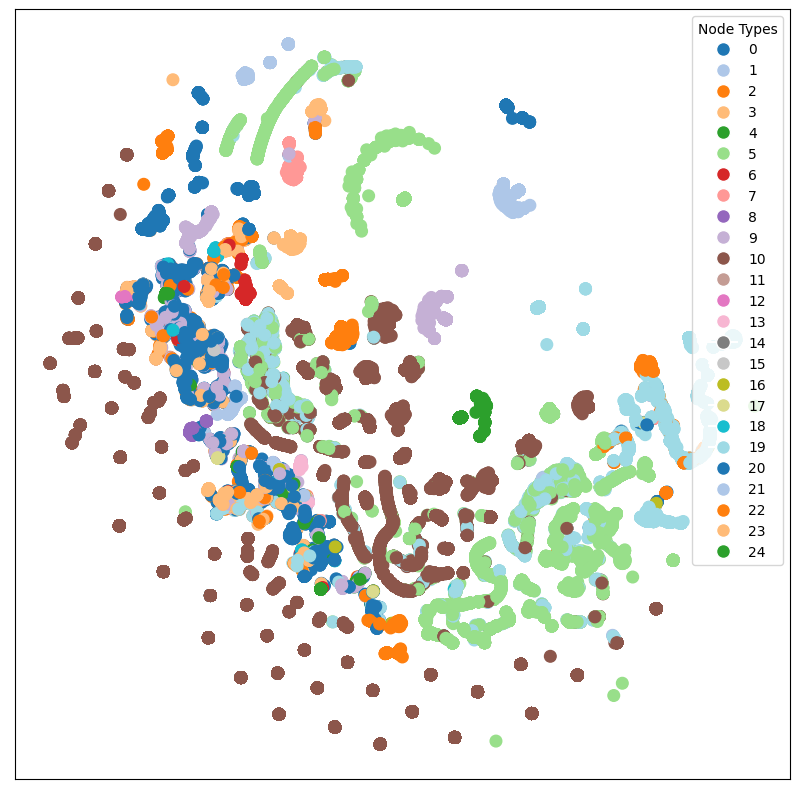

In [34]:
visualize(z,y)

In [ ]:
le = LabelEncoder()
y = le.fit_transform(nodes_df['type'])  # Convert the labels into numerical form

# Print the mapping of encoded values to original node types
print("Encoded Node Type Mapping:")
for i, node_type in enumerate(le.classes_):
    print(f"{i}: {node_type}")

Encoded Node Type Mapping:
0: Anatomy
1: Basic formal
2: Cell
3: Chemical
4: Chromosome
5: Disease
6: Environment
7: Environmental exposure
8: Food
9: GO
10: Gene
11: General medical science
12: Human developmental stage
13: Medical action
14: Mental disease
15: Mental functioning
16: Mouse pathology
17: NCI thesaurus
18: Neuro behaviour
19: Phenotype
20: Protein
21: Sequence
22: Species
23: Vaccine
24: miRNA


In [35]:
len(nodes_df[nodes_df['type'] == 'miRNA'])


4796

In [36]:
torch.save(model, view_path+'GATConv_model_view'+str(view)+'.pth')

In [37]:
import os

# Define the directory and file path
view =2
view_path = f'/home/khushboo/'
predictions_path = os.path.join(view_path, 'predictions')
file_path = os.path.join(predictions_path, f'view{view}_GATConv_node_embeddings_correct.csv')

# Ensure the directory exists
os.makedirs(predictions_path, exist_ok=True)

In [38]:
probs = edges_to_predict_filtered.copy()
probs['probability']=get_prob(external_test_data)
probs.to_csv(view_path+'predictions/view'+str(view)+'_GATConv_node_embeddings_correct.csv')

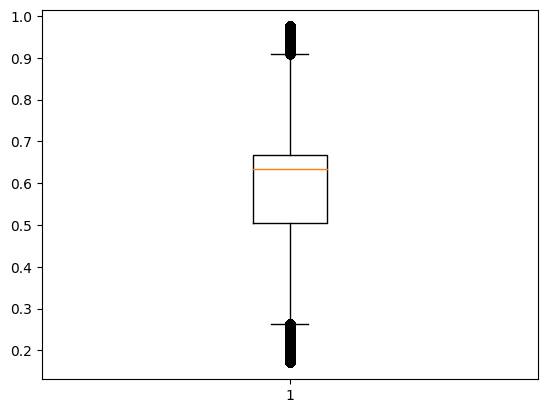

In [39]:
_=plt.boxplot(get_prob(test_data))

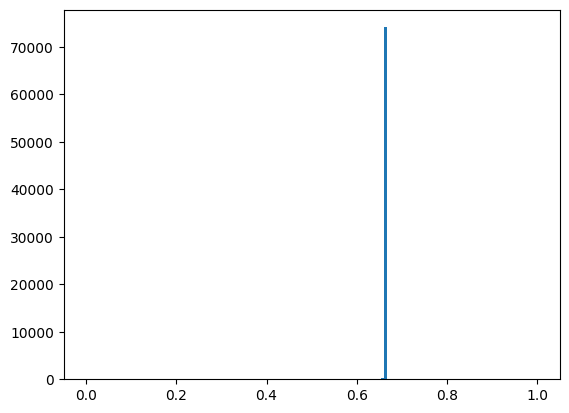

In [40]:
_=plt.hist(get_prob(external_test_data), bins=150, range=[0,1])

In [41]:
nodes_df

,name,type
0,<http://purl.obolibrary.org/obo/SO_0000561>,Sequence
1,<http://purl.obolibrary.org/obo/HP_0033340>,Phenotype
2,<http://purl.obolibrary.org/obo/UBERON_0034713>,Anatomy
3,<http://www.ncbi.nlm.nih.gov/gene/57413>,Gene
4,<https://www.mirbase.org/mature/MIMAT0022474>,miRNA
...,...,...
85294,<http://purl.obolibrary.org/obo/HP_0012854>,Phenotype
85295,<http://purl.obolibrary.org/obo/HP_0031955>,Phenotype
85296,<http://purl.obolibrary.org/obo/HP_0006336>,Phenotype
85297,<http://purl.obolibrary.org/obo/MONDO_0700145>,Disease


In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Prepare the labels
true_labels = nodes_df['type']

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the features and labels
X = z
y = true_labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

In [44]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9676
Precision: 0.9677
Recall: 0.9676


In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Set the minimum threshold for the number of nodes per class
min_samples = 5

# Count the frequency of each node type
node_type_counts = nodes_df['type'].value_counts()

# Filter out node types with fewer than the threshold
common_node_types = node_type_counts[node_type_counts >= min_samples].index

# Filter the data to keep only the common types
filtered_df = nodes_df[nodes_df['type'].isin(common_node_types)]
X_filtered = z[filtered_df.index]  # Embeddings corresponding to the filtered node types
true_labels_filtered = filtered_df['type']

# Encode the labels
le = LabelEncoder()
y_filtered = le.fit_transform(true_labels_filtered)  # Convert the labels into numerical form

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and f1-score for each class (node type)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Print the overall accuracy
print(f"Overall Accuracy: {accuracy:.4f}")

# Print the precision, recall, and f1-score for each class
for i, class_label in enumerate(le.classes_):
    print(f"Class: {class_label}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1 Score: {f1[i]:.4f}")


Overall Accuracy: 0.9686
Class: Anatomy
  Precision: 0.9138
  Recall: 0.9527
  F1 Score: 0.9328
Class: Cell
  Precision: 0.9241
  Recall: 0.8795
  F1 Score: 0.9012
Class: Chemical
  Precision: 0.9038
  Recall: 0.9066
  F1 Score: 0.9052
Class: Chromosome
  Precision: 0.9239
  Recall: 0.9341
  F1 Score: 0.9290
Class: Disease
  Precision: 0.9693
  Recall: 0.9828
  F1 Score: 0.9760
Class: Environment
  Precision: 0.9597
  Recall: 0.8750
  F1 Score: 0.9154
Class: Environmental exposure
  Precision: 0.9828
  Recall: 0.9913
  F1 Score: 0.9870
Class: Food
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Class: GO
  Precision: 0.9393
  Recall: 0.9252
  F1 Score: 0.9322
Class: Gene
  Precision: 0.9903
  Recall: 0.9915
  F1 Score: 0.9909
Class: General medical science
  Precision: 1.0000
  Recall: 0.3333
  F1 Score: 0.5000
Class: Human developmental stage
  Precision: 0.9167
  Recall: 0.8800
  F1 Score: 0.8980
Class: Medical action
  Precision: 0.9302
  Recall: 1.0000
  F1 Score: 0.9639
Cl

class wise presicion

In [46]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the labels
true_labels = nodes_df['type']
X =  z

# Encode the labels
le = LabelEncoder()
y = le.fit_transform(true_labels)  # Convert the labels into numerical form

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42,  class_weight='balanced')
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and f1-score for each class (node type)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Print the overall accuracy
print(f"Overall Accuracy: {accuracy:.4f}")

for i, class_label in enumerate(le.classes_):
    try:
        print(f"Class: {class_label}")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1 Score: {f1[i]:.4f}")
    except IndexError:
        print(f"Class: {class_label}")
        print("  Precision: 0.0000 (No predictions for this class)")
        print("  Recall: 0.0000")
        print("  F1 Score: 0.0000")


Overall Accuracy: 0.9677
Class: Anatomy
  Precision: 0.9090
  Recall: 0.9482
  F1 Score: 0.9282
Class: Basic formal
  Precision: 0.9079
  Recall: 0.8375
  F1 Score: 0.8713
Class: Cell
  Precision: 0.8899
  Recall: 0.8956
  F1 Score: 0.8927
Class: Chemical
  Precision: 0.9000
  Recall: 0.9419
  F1 Score: 0.9205
Class: Chromosome
  Precision: 0.9726
  Recall: 0.9847
  F1 Score: 0.9786
Class: Disease
  Precision: 0.9206
  Recall: 0.8657
  F1 Score: 0.8923
Class: Environment
  Precision: 0.9699
  Recall: 1.0000
  F1 Score: 0.9847
Class: Environmental exposure
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Class: Food
  Precision: 0.9282
  Recall: 0.9128
  F1 Score: 0.9204
Class: GO
  Precision: 0.9922
  Recall: 0.9914
  F1 Score: 0.9918
Class: Gene
  Precision: 1.0000
  Recall: 0.3333
  F1 Score: 0.5000
Class: General medical science
  Precision: 0.9500
  Recall: 0.9048
  F1 Score: 0.9268
Class: Human developmental stage
  Precision: 0.8636
  Recall: 1.0000
  F1 Score: 0.9268
Clas

In [47]:
from grape import Graph
rna_kg_graph = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=False,
    name=view_name,
)

rna_kg_graph_directed = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=True,
    name=view_name+"_directed",
)

In [48]:
graph = rna_kg_graph_directed
# Function to simplify node names
def simplify_node_names(graph):
    simplified_node_names = [name[0] for name in graph.get_node_names()]
    return simplified_node_names

# Apply to the graph
simplified_node_names = simplify_node_names(graph)

In [56]:
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[RandomForestEdgePrediction()],
    number_of_holdouts=5,
    node_features=z,  # Use simplified embedding features
    smoke_test=True,
    enable_cache=False
)

Evaluating on VIEW2_directed:   0%|          | 0/5 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

In [57]:
results = pd.concat([results, evaluation], ignore_index = True)
filename = "results_"+view_name+"_FirstOrderLINE.csv"
results.to_csv(filename)

In [58]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,precision,diagnostic_odds_ratio,prevalence,false_discovery_rate,false_omission_rate,threat_score,...,"(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, bootstrap)","(model_parameters, oob_score)","(model_parameters, n_jobs)","(model_parameters, verbose)","(model_parameters, warm_start)","(model_parameters, ccp_alpha)","(model_parameters, max_samples)"
0,train,0.8,1.0,True,0.487523,0.938742,0.5,0.512477,0.503324,0.168731,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
1,test,0.8,1.0,True,0.441734,0.748110,0.5,0.558266,0.514016,0.140825,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
2,train,0.8,1.0,True,0.487695,0.939564,0.5,0.512305,0.503277,0.168756,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
3,test,0.8,1.0,True,0.443729,0.755868,0.5,0.556271,0.513459,0.141013,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
4,train,0.8,1.0,True,0.486950,0.936104,0.5,0.513050,0.503454,0.167780,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
5,test,0.8,1.0,True,0.443721,0.756095,0.5,0.556279,0.513375,0.140410,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
6,train,0.8,1.0,True,0.487943,0.940738,0.5,0.512057,0.503213,0.168946,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
7,test,0.8,1.0,True,0.442299,0.750591,0.5,0.557701,0.513761,0.140226,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
8,train,0.8,1.0,True,0.486469,0.933694,0.5,0.513531,0.503617,0.168686,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
9,test,0.8,1.0,True,0.442741,0.752155,0.5,0.557259,0.513688,0.140603,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None


In [50]:
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction


In [52]:
evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[DecisionTreeEdgePrediction()],
    number_of_holdouts=5,
    node_features=z,  # Use simplified embedding features
    smoke_test=False
)


In [53]:
results = evaluation
filename = "results_"+view_name+"_FirstOrderLINE_DesicionTree_gatconv.csv"
results.to_csv(filename)

In [54]:
# Separate train and test results
train_results = evaluation[evaluation['evaluation_mode'] == 'train']
test_results = evaluation[evaluation['evaluation_mode'] == 'test']

# Function to compute mean metrics for a given evaluation mode
def compute_mean_metrics(data):
    results = []
    for holdout in data['holdout_number'].unique():
        holdout_data = data[data['holdout_number'] == holdout]

        # Calculate mean values for metrics
        auc_score = holdout_data['auroc'].mean()
        precision = holdout_data['precision'].mean()
        recall = holdout_data['recall'].mean()
        f1_score = holdout_data['f1_score'].mean()
        accuracy = holdout_data['accuracy'].mean()  # Assuming 'accuracy' column exists

        # Append results for this holdout
        results.append({
            'Holdout': holdout,
            'AUC': auc_score,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'Accuracy': accuracy
        })

    # Convert to DataFrame
    return pd.DataFrame(results)

# Compute metrics for train and test
train_metrics_df = compute_mean_metrics(train_results)
test_metrics_df = compute_mean_metrics(test_results)

# Calculate overall mean for train and test
overall_train_mean = train_metrics_df.mean(numeric_only=True)
overall_test_mean = test_metrics_df.mean(numeric_only=True)

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Evaluation Mode': ['Train', 'Test'],
    'AUC': [overall_train_mean['AUC'], overall_test_mean['AUC']],
    'Precision': [overall_train_mean['Precision'], overall_test_mean['Precision']],
    'Recall': [overall_train_mean['Recall'], overall_test_mean['Recall']],
    'F1 Score': [overall_train_mean['F1 Score'], overall_test_mean['F1 Score']],
    'Accuracy': [overall_train_mean['Accuracy'], overall_test_mean['Accuracy']]
})

# Display the summary of mean metrics
print(summary_df)


  Evaluation Mode       AUC  Precision    Recall  F1 Score  Accuracy
0           Train  0.836038   0.791428  0.151332  0.254078  0.555721
1            Test  0.829315   0.704101  0.095316  0.167900  0.527625


In [55]:
test_results = evaluation[evaluation['evaluation_mode'] == 'test']

# Check if the filtering worked
print(test_results)

# List to store metrics for plotting
results = []

# Loop through each holdout for test results
for holdout in test_results['holdout_number'].unique():
    # Extract metrics for this holdout
    holdout_data = test_results[test_results['holdout_number'] == holdout]
    
    # Calculate mean values for the metrics
    auc_score = holdout_data['auroc'].mean()
    precision = holdout_data['precision'].mean()
    recall = holdout_data['recall'].mean()
    f1_score = holdout_data['f1_score'].mean()

    # Append results for this holdout
    results.append({
        'Holdout': holdout,
        'AUC': auc_score,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    })

# Create a DataFrame to summarize the filtered test results
results_df = pd.DataFrame(results)

# Print the results for test mode
print(results_df)

  evaluation_mode  train_size  validation_unbalance_rate  \
1            test         0.8                        1.0   
1            test         0.8                        1.0   
1            test         0.8                        1.0   
1            test         0.8                        1.0   
1            test         0.8                        1.0   

   use_scale_free_distribution    recall  false_omission_rate  informedness  \
1                         True  0.096765             0.484210      0.058908   
1                         True  0.096130             0.485542      0.053830   
1                         True  0.093663             0.485897      0.052612   
1                         True  0.096143             0.484683      0.057128   
1                         True  0.093876             0.485591      0.053774   

   balanced_accuracy  miss_rate  negative_predictive_value  ...  \
1           0.529454   0.903235                   0.515790  ...   
1           0.526915   0.90387

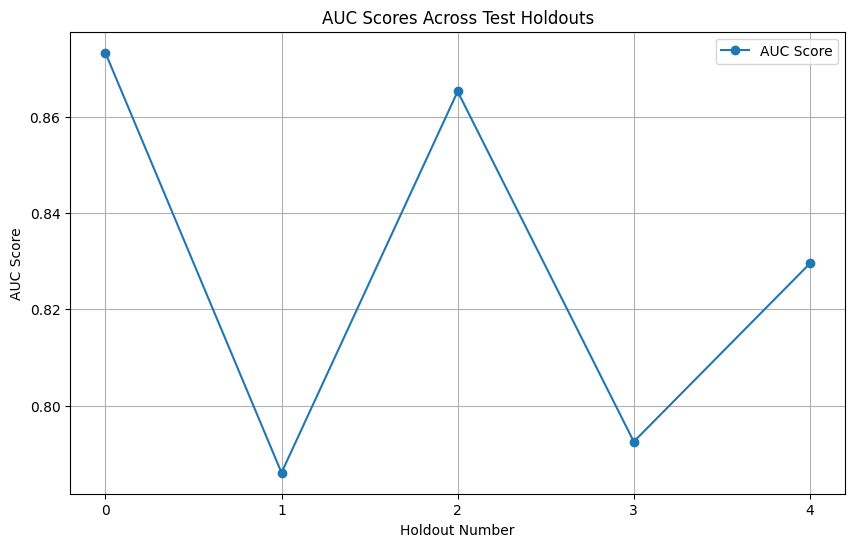

In [56]:
# Plotting AUC Scores for test mode
plt.figure(figsize=(10, 6))
plt.plot(results_df['Holdout'], results_df['AUC'], marker='o', label='AUC Score')
plt.title('AUC Scores Across Test Holdouts')
plt.xlabel('Holdout Number')
plt.ylabel('AUC Score')
plt.xticks(results_df['Holdout'])
plt.grid()
plt.legend()
plt.show()
